

# Libraries

Video: https://www.youtube.com/watch?v=DEHqIxX1Kq4&t=924s&ab_channel=NextDayVideo

In [ ]:
!pip install pgmpy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Model

from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.models import BayesianModel

#Inferences
from pgmpy.inference import VariableElimination


# Setting up the model

## Set the structure

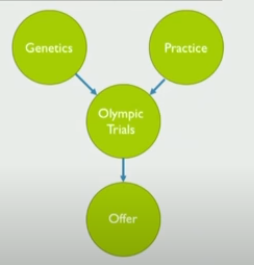

In [ ]:
olympic_model = BayesianModel([('Genetics', 'OlympicTrials'),
                             ('Practice', 'OlympicTrials'),
                             ('OlympicTrials', 'Offer')])

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


## set up the relationships (the CPDs)

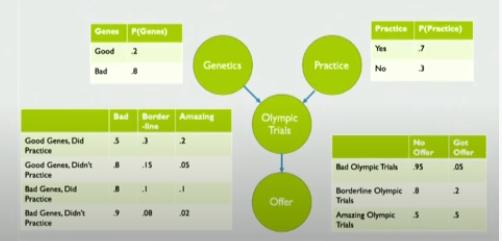

In [ ]:
genetics_cpd = TabularCPD(
                variable = 'Genetics',
                variable_card = 2,
                values = [[0.2],[0.8]])

In [ ]:
practice_cpd = TabularCPD(
                variable = 'Practice',
                variable_card = 2,
                values = [[.7],[.3]])

In [ ]:
offer_cpd = TabularCPD(
                    variable = 'Offer',
                    variable_card = 2,
                    values = [[.95, .8, .5],
                             [.05, .2, .5]],
                    evidence = ['OlympicTrials'],
                    evidence_card = [3])

In [ ]:
olympic_trials_cpd = TabularCPD(
                        variable = 'OlympicTrials', 
                        variable_card = 3,
                        values = [[.5, .8, .8, .9],
                                 [.3, .15, .1, .08],
                                 [.2, .05, .1, .02]],
                        evidence = ['Genetics', 'Practice'],
                        evidence_card = [2,2])

## Add the relationships to the models


In [ ]:
olympic_model.add_cpds (genetics_cpd, practice_cpd, offer_cpd, olympic_trials_cpd)

## Examine the structure of the graph


In [ ]:
olympic_model.get_cpds()


[<TabularCPD representing P(Genetics:2) at 0x7f85d34c2850>,
 <TabularCPD representing P(Practice:2) at 0x7f85d34baa10>,
 <TabularCPD representing P(Offer:2 | OlympicTrials:3) at 0x7f85d3d479d0>,
 <TabularCPD representing P(OlympicTrials:3 | Genetics:2, Practice:2) at 0x7f85d3d9b790>]

## Find active trail nodes


(nodes that give information about each others)


In [ ]:
olympic_model.active_trail_nodes('Genetics')


{'Genetics': {'Genetics', 'Offer', 'OlympicTrials'}}

In [ ]:
olympic_model.active_trail_nodes('OlympicTrials')


{'OlympicTrials': {'Genetics', 'Offer', 'OlympicTrials', 'Practice'}}

## Find local independencies

In [ ]:
olympic_model.local_independencies('Genetics')


(Genetics ⟂ Practice)

Genetics is independent of practice

In [ ]:
olympic_model.local_independencies('OlympicTrials')


OlympicTrials is not independent 

## Get all independencies


In [ ]:
olympic_model.get_independencies()


(Genetics ⟂ Practice)
(Genetics ⟂ Offer | OlympicTrials)
(Genetics ⟂ Offer | OlympicTrials, Practice)
(Offer ⟂ Genetics, Practice | OlympicTrials)
(Offer ⟂ Practice | OlympicTrials, Genetics)
(Offer ⟂ Genetics | OlympicTrials, Practice)
(Practice ⟂ Genetics)
(Practice ⟂ Offer | OlympicTrials)
(Practice ⟂ Offer | OlympicTrials, Genetics)

(Genetics ⟂ Offer | OlympicTrials) ---> Genetics independent of Offer when we know OlympicTrials

# Making inferences



## We can get probability distributions that are not explicitly spelled out in our graphs

In [ ]:
olympic_infer = VariableElimination(olympic_model)


In [ ]:
prob_offer = olympic_infer.query(variables = ['Offer'])
print(prob_offer)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

+----------+--------------+
| Offer    |   phi(Offer) |
+==========+==============+
| Offer(0) |       0.8898 |
+----------+--------------+
| Offer(1) |       0.1102 |
+----------+--------------+


## We can also get conditional probability distributions that take into account what we already know



In [ ]:
prob_offer_bad_genes = olympic_infer.query(
                                        variables = ['Offer'], 
                                        evidence = {'Genetics':1})
print(prob_offer_bad_genes)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+----------+--------------+
| Offer    |   phi(Offer) |
+==========+==============+
| Offer(0) |       0.9017 |
+----------+--------------+
| Offer(1) |       0.0983 |
+----------+--------------+


In [ ]:
prob_offer_good_genes = olympic_infer.query(
                                        variables = ['Offer'], 
                                        evidence = {'Genetics':0})
print(prob_offer_good_genes)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

+----------+--------------+
| Offer    |   phi(Offer) |
+==========+==============+
| Offer(0) |       0.8420 |
+----------+--------------+
| Offer(1) |       0.1580 |
+----------+--------------+


In [ ]:
prob_offer_good_genes_did_practice = olympic_infer.query(
                                        variables = ['Offer'], 
                                        evidence = {'Genetics':0, 'Practice':0})
print(prob_offer_good_genes_did_practice)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+----------+--------------+
| Offer    |   phi(Offer) |
+==========+==============+
| Offer(0) |       0.8150 |
+----------+--------------+
| Offer(1) |       0.1850 |
+----------+--------------+


## We can also go upstream logically. For example, evidence about performance at the Olympic Trials affects the probabilities of Genetics.

In [ ]:
prob_good_genes_if_amazing_olympic_trials = olympic_infer.query(
                                        variables = ['Genetics'], 
                                        evidence = {'OlympicTrials':2})
print(prob_good_genes_if_amazing_olympic_trials)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

+-------------+-----------------+
| Genetics    |   phi(Genetics) |
+=============+=================+
| Genetics(0) |          0.3377 |
+-------------+-----------------+
| Genetics(1) |          0.6623 |
+-------------+-----------------+


## Some variables are only informative about other variables given 'third' variables

In [ ]:

prob_good_genes_if_no_practice = olympic_infer.query(
                                        variables = ['Genetics'], 
                                        evidence = {'Practice':1})
print(prob_good_genes_if_no_practice)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------+-----------------+
| Genetics    |   phi(Genetics) |
+=============+=================+
| Genetics(0) |          0.2000 |
+-------------+-----------------+
| Genetics(1) |          0.8000 |
+-------------+-----------------+


Practice does not inherently tell us something about Genetics

In [ ]:

prob_good_genes_if_no_practice_good_olympic_trials = olympic_infer.query(
                                        variables = ['Genetics'], 
                                        evidence = {'Practice':1,
                                                   'OlympicTrials':2})
print(prob_good_genes_if_no_practice_good_olympic_trials)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+-------------+-----------------+
| Genetics    |   phi(Genetics) |
+=============+=================+
| Genetics(0) |          0.3846 |
+-------------+-----------------+
| Genetics(1) |          0.6154 |
+-------------+-----------------+


BUT Practice does tell us something about genetics IF we also know something about olympic trials performance

## We can find out the most probable state for a variable


----> Most likely

In [ ]:
olympic_infer.map_query(variables = ['Genetics'])


0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'Genetics': 1}

{'Genetics': 1} ---> most likely genetics is Good

In [ ]:
olympic_infer.map_query(variables = ['Offer'])


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'Offer': 0}

In [ ]:
olympic_infer.map_query(variables = ['OlympicTrials'])


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'OlympicTrials': 0}